In [2]:
import os
import pandas as pd
from tqdm import tqdm
import warnings
import re
import trimesh
import numpy as np
import time
import traceback
import sys

warnings.filterwarnings("ignore")

# 1. Get meta data

## 1. Calculate branches counts

In [19]:
import os
import pandas as pd
from tqdm import tqdm  

def count_soma_children_and_radius(swc_file):
    """
    Parse the SWC file to count the number of child nodes connected to the soma,
    and extract the soma radius (second-to-last column of soma node).
    Assumes soma nodes have type 1 (according to the SWC format).
    """
    soma_children = 0
    soma_coordinates = None
    soma_node_ids = []
    soma_radius = None  

    # Reading the SWC file to find soma node and coordinates
    with open(swc_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) < 7:
                continue

            node_id = int(parts[0])
            node_type = int(parts[1])

            # If node type is soma (type == 1), store its id, coordinates, and radius (second-to-last column)
            if node_type == 1:
                soma_node_ids.append(node_id)
                soma_coordinates = (float(parts[2]), float(parts[3]), float(parts[4]))
                soma_radius = float(parts[5])/1000  

    # Count the children of soma nodes
    with open(swc_file, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            parts = line.split()
            if len(parts) < 7:
                continue

            parent_id = int(parts[6])  
            node_type = int(parts[1])  

            # Check if the node is a child of the soma
            if parent_id in soma_node_ids and node_type != 1:
                soma_children += 1

    return soma_children, soma_coordinates, soma_radius

def process_swc_files(folder_path):
    """
    Traverse all SWC files in the given folder, count soma's child nodes,
    extract the soma radius, and organize the data into a DataFrame.
    """
    data = []
    
    # Get all .swc files in the folder
    swc_files = [f for f in os.listdir(folder_path) if f.endswith('.swc')]

    # Use tqdm to show a progress bar while processing the files
    for filename in tqdm(swc_files, desc="Processing SWC files"):
        swc_file_path = os.path.join(folder_path, filename)
        soma_children, soma_coordinates, soma_radius = count_soma_children_and_radius(swc_file_path)

        # Remove the file extension (.swc) from the filename
        filename_without_extension = os.path.splitext(filename)[0]

        if soma_coordinates:
            x, y, z = [coord / 1000 for coord in soma_coordinates]
        else:
            x, y, z = None, None, None

        # Determine the type based on the number of children connected to soma
        if soma_children == 1:
            soma_type = "Unipolar"
        elif soma_children == 2:
            soma_type = "Bipolar"
        else:
            soma_type = "Multipolar"

        # Append the data
        data.append({
            'Name': filename_without_extension,
            'x': x,
            'y': y,
            'z': z,
            'branches_count': soma_children,
            'type': soma_type,
            'radius': soma_radius 
        })

    # Create a DataFrame from the collected data
    df = pd.DataFrame(data)
    return df

# Specify the folder path of 'data_rename'
folder_path = 'data_rename'
df_swc = process_swc_files(folder_path)

# Display the resulting DataFrame
df_swc

Processing SWC files: 100%|██████████████████████████████████████████████████████████████| 134689/134689 [11:59<00:00, 187.26it/s]


,Name,x,y,z,branches_count,type,radius
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681
...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784


In [20]:
branches_df = df_swc
out_path = 'dataframe_data/branches_data.csv'
branches_df.to_csv(out_path, index=False, header=True, sep=',')

## 2. Annotate brain region information

In [9]:
left_brain_path = "~/fly/code/BrainParcellation-main/data/search_results_side_left.csv"
right_brain_path = "~/fly/code/BrainParcellation-main/data/search_results_side_right.csv"
center_brain_path = "~/fly/code/BrainParcellation-main/data/search_results_side_center.csv"
main_region = ['AMMC','FLA','CAN','AL','LH','MB_CA',
 'MB_PED','MB_VL','MB_ML','BU','GA','LAL','SLP','SIP','SMP',
'CRE','SCL','ICL','IB','ATL','VES','EPA','GOR','SPS',
'IPS','AOTU','AVLP','PVLP','PLP','WED','ME','AME','LO',
'LOP','LA']
region_list = ['FB', 'EB', 'PB', 'NO', 'PRW', 'SAD', 'GNG', 'OCG']

#############
left_neuron_df = pd.read_csv(left_brain_path, dtype={0: str})
left_neuron_df.iloc[:, 2] = left_neuron_df.iloc[:, 2].astype(str).str.split('.').str[0]
left_neuron_df = left_neuron_df.iloc[:, [0, 2]].dropna()
left_neuron_df.columns = ['Name', 'Soma_region']
left_neuron_df = left_neuron_df[left_neuron_df.iloc[:, 1].isin(main_region+region_list)]
left_neuron_df.iloc[:, 1] = left_neuron_df.iloc[:, 1].apply(
    lambda x: x + '_L' if x not in region_list else x
)
###########
right_neuron_df = pd.read_csv(right_brain_path, dtype={0: str})
right_neuron_df.iloc[:, 2] = right_neuron_df.iloc[:, 2].astype(str).str.split('.').str[0]
right_neuron_df = right_neuron_df.iloc[:, [0, 2]].dropna()
right_neuron_df.columns = ['Name', 'Soma_region']
right_neuron_df = right_neuron_df[right_neuron_df.iloc[:, 1].isin(main_region+region_list)]
right_neuron_df.iloc[:, 1] = right_neuron_df.iloc[:, 1].apply(
    lambda x: x + '_R' if x not in region_list else x
)
###########
center_neuron_df = pd.read_csv(center_brain_path, dtype={0: str})
center_neuron_df.iloc[:, 2] = center_neuron_df.iloc[:, 2].astype(str).str.split('.').str[0]
center_neuron_df = center_neuron_df.iloc[:, [0, 2]].dropna()
center_neuron_df.columns = ['Name', 'Soma_region']
center_neuron_df = center_neuron_df[center_neuron_df.iloc[:, 1].isin(region_list)]


all_neuron_df = pd.concat([left_neuron_df, right_neuron_df, center_neuron_df], ignore_index=True)
all_neuron_df

,Name,Soma_region
0,720575940650527222,SMP_L
1,720575940603765280,SMP_L
2,720575940616153371,PRW
3,720575940618385718,PRW
4,720575940622897639,SMP_L
...,...,...
134111,720575940639662069,GNG
134112,720575940640133083,GNG
134113,720575940641211520,GNG
134114,720575940641836232,GNG


In [12]:
metadata_df = pd.merge(branches_df, all_neuron_df, on='Name', how='left')
metadata_df.rename(columns={'x': 'soma_x', 'y': 'soma_y', 'z': 'soma_z'}, inplace=True)
metadata_df

,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927,PLP_L
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095,LA_R
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607,ME_R
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681,PVLP_L
...,...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697,ME_R
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258,ME_L
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102,IPS_R
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784,ME_R


## 3.Get soma prejected coord

In [13]:
import os
import numpy as np
import pandas as pd
import trimesh
from tqdm import tqdm
import random  

def find_closest_surface_point(cell, mesh):
    cell = np.expand_dims(cell, axis=0)  
    closest_point = mesh.nearest.on_surface(cell) 
    return closest_point[0]  

def load_all_obj_meshes(directory_path):
    meshes = []
    for file in os.listdir(directory_path):
        if file.endswith('.obj'):
            file_path = os.path.join(directory_path, file)
            mesh = trimesh.load(file_path)
            meshes.append(mesh)
    return meshes

def sink_point(original, projected, sink_distance=0.1):
    direction = projected - original
    
    direction_norm = direction / np.linalg.norm(direction)
    
    sunk_point = projected + direction_norm * sink_distance
    return sunk_point

def project_to_surface(cell, meshes, sink_distance=1.5):
    for mesh in meshes:
        if mesh.contains([cell]):
            return cell
    
    for mesh in meshes:
        [projected_point] = find_closest_surface_point(cell, mesh)
        projected_point = np.array(projected_point).reshape(1, 3)  
        
        #sink_distance = random.uniform(min_sink_distance, max_sink_distance) 
        sink_distance = sink_distance
        
        sunk_point = sink_point(cell, projected_point.flatten(), sink_distance)
        return sunk_point
    
    return np.nan, np.nan, np.nan
##########################################################################################

obj_list = [
    'AMMC_L', 'FLA_L', 'CAN_L', 'AL_L', 'LH_L', 'MB_CA_L', 'MB_PED_L', 'MB_VL_L', 'MB_ML_L', 'BU_L', 'GA_L',
    'LAL_L', 'SLP_L', 'SIP_L', 'SMP_L', 'CRE_L', 'SCL_L', 'ICL_L', 'IB_L', 'ATL_L', 'VES_L', 'EPA_L', 'GOR_L',
    'SPS_L', 'IPS_L', 'AOTU_L', 'AVLP_L', 'PVLP_L', 'PLP_L', 'WED_L', 'ME_L', 'AME_L', 'LO_L', 'LOP_L', 'LA_L',
    'AMMC_R', 'FLA_R', 'CAN_R', 'AL_R', 'LH_R', 'MB_CA_R', 'MB_PED_R', 'MB_VL_R', 'MB_ML_R', 'BU_R', 'GA_R',
    'LAL_R', 'SLP_R', 'SIP_R', 'SMP_R', 'CRE_R', 'SCL_R', 'ICL_R', 'IB_R', 'ATL_R', 'VES_R', 'EPA_R', 'GOR_R',
    'SPS_R', 'IPS_R', 'AOTU_R', 'AVLP_R', 'PVLP_R', 'PLP_R', 'WED_R', 'ME_R', 'AME_R', 'LO_R', 'LOP_R', 'LA_R',
    'FB', 'EB', 'PB', 'NO', 'PRW', 'SAD', 'GNG', 'OCG'
]

for obj_name in obj_list:
    obj_path = f'/home/ylx/fly/code/BrainParcellation-main/data/fly_mesh/{obj_name}.obj'
    obj = trimesh.load(obj_path)
    globals()[obj_name] = obj  

df = metadata_df.copy()
projected_coords = []

for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    if pd.isna(row['soma_x']) or pd.isna(row['soma_y']) or pd.isna(row['soma_z']):
        projected_coords.append([np.nan, np.nan, np.nan])  
        continue  
    
    cell = np.array([row['soma_x'], row['soma_y'], row['soma_z']])
    mesh_name = row['Soma_region']  
    if mesh_name in globals():
        meshes = [globals()[mesh_name]] 
    else:
        meshes = []
    #projected_point = project_to_surface(cell, meshes, min_sink_distance=2, max_sink_distance=2.1)
    projected_point = project_to_surface(cell, meshes, sink_distance=1.5)
    projected_coords.append(projected_point)  

df['projected_x'] = [coord[0] for coord in projected_coords]
df['projected_y'] = [coord[1] for coord in projected_coords]
df['projected_z'] = [coord[2] for coord in projected_coords]

df

100%|████████████████████████████████████████████████████████████████████████████████████| 134689/134689 [05:17<00:00, 424.17it/s]


,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L,138.090890,365.160530,157.406030
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927,PLP_L,426.890432,235.348252,209.753087
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095,LA_R,830.562572,252.049488,82.309802
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607,ME_R,737.149300,318.612314,94.126347
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681,PVLP_L,356.488295,193.495347,172.147376
...,...,...,...,...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697,ME_R,819.250674,253.126543,224.022500
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258,ME_L,267.175712,210.982766,251.874520
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102,IPS_R,561.989303,236.822731,184.282588
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784,ME_R,700.979290,307.190783,123.747950


In [14]:
df_projected = df
df_projected

,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L,138.090890,365.160530,157.406030
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927,PLP_L,426.890432,235.348252,209.753087
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095,LA_R,830.562572,252.049488,82.309802
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607,ME_R,737.149300,318.612314,94.126347
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681,PVLP_L,356.488295,193.495347,172.147376
...,...,...,...,...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697,ME_R,819.250674,253.126543,224.022500
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258,ME_L,267.175712,210.982766,251.874520
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102,IPS_R,561.989303,236.822731,184.282588
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784,ME_R,700.979290,307.190783,123.747950


In [15]:
out_path = 'dataframe_data/projected_soma.csv'
df_projected.to_csv(out_path, index=False, header=True, sep=',')

In [16]:
file_path = 'dataframe_data/projected_soma.csv'
df_projected = pd.read_csv(file_path, dtype={0: str})
df_projected

,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L,138.090890,365.160530,157.406030
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927,PLP_L,426.890432,235.348252,209.753087
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095,LA_R,830.562572,252.049488,82.309802
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607,ME_R,737.149300,318.612314,94.126347
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681,PVLP_L,356.488295,193.495347,172.147376
...,...,...,...,...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697,ME_R,819.250674,253.126543,224.022500
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258,ME_L,267.175712,210.982766,251.874520
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102,IPS_R,561.989303,236.822731,184.282588
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784,ME_R,700.979290,307.190783,123.747950


## 4.Determine whether soma is in the brain

In [17]:
# Load the mesh
def load_mesh(obj_path):
    mesh = trimesh.load(obj_path)
    return mesh

# Calculate the distance from a point to the nearest point on the mesh
def point_to_mesh_distance(point, mesh):
    closest_point, index = mesh.nearest.vertex([point])
    distance = np.linalg.norm(np.array(point) - closest_point)
    return distance

# Load all meshes from the specified folder
obj_path = '/home/ylx/fly/code/BrainParcellation-main/data/fly_mesh/'

mesh_objects = {}
for file in os.listdir(obj_path):
    if file.endswith('.obj'):
        mesh_objects[file] = load_mesh(os.path.join(obj_path, file))

# Check if a point is within the brain (in the mesh)
def is_within_bounds(point, mesh):
    point = np.array(point).reshape(1, 3)
    is_inside = mesh.contains(point)[0]
    return is_inside

# Check if a point is within the brain or within the soma radius from the surface
def check_point_in_brain(row, point_col_prefix):
    if pd.isna(row[f'{point_col_prefix}_x']) or pd.isna(row[f'{point_col_prefix}_y']) or pd.isna(row[f'{point_col_prefix}_z']) or pd.isna(row['radius']):
        return 'No'
    #print(row)
    point = (row[f'{point_col_prefix}_x'], row[f'{point_col_prefix}_y'], row[f'{point_col_prefix}_z'])
    soma_radius = row['radius']/2  # Use the radius from the DataFrame
    
    # Check if the point is inside the brain or within soma's radius of the surface
    for mesh_file, mesh in mesh_objects.items():
        # Check if the point is inside the mesh
        if mesh.contains([point])[0]:
            return 'Yes'
        
        # Check if the point is within soma's radius of the surface
        distance = point_to_mesh_distance(point, mesh)
        if distance <= soma_radius:  # Use soma_radius instead of fixed 1.2 micrometers
            return 'Yes'
    
    return 'No'

# Main processing function to update the DataFrame
df = df_projected.copy()
list_of_points = df[['projected_x', 'projected_y', 'projected_z']].values

tqdm.pandas(desc="Checking if Points are in Brain")
df['in_brain'] = df.progress_apply(lambda row: check_point_in_brain(row, 'soma'), axis=1)

df['in_brain_numeric'] = df['in_brain'].map({'Yes': 1, 'No': 0})

# Sum the soma points that are in the brain
soma_sum = df['in_brain_numeric'].sum()
print(f"Soma regions in brain: {soma_sum}")

# Display the resulting DataFrame
df

Checking if Points are in Brain: 100%|███████████████████████████████████████████████████| 134689/134689 [14:07<00:00, 158.93it/s]


Soma regions in brain: 19190


,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z,in_brain,in_brain_numeric
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L,138.090890,365.160530,157.406030,Yes,1
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927,PLP_L,426.890432,235.348252,209.753087,No,0
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095,LA_R,830.562572,252.049488,82.309802,No,0
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607,ME_R,737.149300,318.612314,94.126347,No,0
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681,PVLP_L,356.488295,193.495347,172.147376,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697,ME_R,819.250674,253.126543,224.022500,No,0
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258,ME_L,267.175712,210.982766,251.874520,No,0
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102,IPS_R,561.989303,236.822731,184.282588,No,0
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784,ME_R,700.979290,307.190783,123.747950,No,0


In [18]:
out_path = 'dataframe_data/meta_data.csv'
df.to_csv(out_path, index=False, header=True, sep=',')

# 2.Access axonal/dendritic information

## Save dendrite/axon coordinates

In [25]:
file_path = 'G:\\energency_fly\\data\\synapse_coordinates\\synapse_coordinates_full.csv'
data = pd.read_csv(file_path, dtype={0: str, 1: str})
data

,pre_root_id,post_root_id,x,y,z
0,720575940596125868,720575940608552405,705988,275676,221800
1,720575940596125868,720575940608552405,706908,275084,222160
2,720575940596125868,720575940608552405,707848,275456,222100
3,720575940596125868,720575940608552405,708050,275176,222200
4,720575940596125868,720575940608552405,711344,267664,223360
...,...,...,...,...,...
34156315,720575940661337217,720575940652390134,436160,163856,81040
34156316,720575940661337217,720575940652390134,436370,165082,78360
34156317,720575940661337217,720575940652390134,438644,167636,77860
34156318,720575940661337217,720575940652390134,442126,167062,78700


In [119]:
%%writefile  temp_multi.py

import os
import pandas as pd
from tqdm import tqdm
import warnings
import re
import trimesh
import numpy as np
import time
from multiprocessing import Pool

warnings.filterwarnings("ignore")

def load_mesh(obj_path):
    return trimesh.load(obj_path)

def load_neuron_data(neuron, pre_path, post_path):
    pre_file = os.path.join(pre_path, neuron + '.swc')
    post_file = os.path.join(post_path, neuron + '.swc')
    
    pre_points, post_points = None, None

    if os.path.exists(pre_file):
        pre_cord_df = pd.read_csv(pre_file, delim_whitespace=True, header=None)
        pre_points = pre_cord_df.iloc[:, 2:5].values / 1000 

    if os.path.exists(post_file):
        post_cord_df = pd.read_csv(post_file, delim_whitespace=True, header=None)
        post_points = post_cord_df.iloc[:, 2:5].values / 1000

    return pre_points, post_points

def calculate_ratio(count_in_mesh_pre, count_in_mesh_post):
    if count_in_mesh_pre + count_in_mesh_post > 0:
        return round((count_in_mesh_pre - count_in_mesh_post) / (count_in_mesh_pre + count_in_mesh_post), 5)
    return 0

obj_path = 'G:\\energency_fly\\data\\fly_mesh\\data'
mesh_objects = {file: load_mesh(os.path.join(obj_path, file)) for file in os.listdir(obj_path) if file.endswith('.obj')}

final_results_df = None
pre_path = 'G:\\energency_fly\\data\\pre_neurites\\'
post_path = 'G:\\energency_fly\\data\\post_neurites\\'

pre_set = {f[:-4] for f in os.listdir(pre_path) if f.endswith('.swc')}
post_set = {f[:-4] for f in os.listdir(post_path) if f.endswith('.swc')}

file_path = 'G:\\energency_fly\\data\\synapse_coordinates\\meta_data.csv'
df = pd.read_csv(file_path, dtype={0: str})

def processing(obj):
#for obj in mesh_objects:
    region_name = os.path.splitext(obj)[0]
    irl = []
    pre_count = []
    post_count = []

    for neuron in df.iloc[:,0].values:
        if neuron in pre_set or neuron in post_set:
            pre_points, post_points = load_neuron_data(neuron, pre_path, post_path)
            
            count_in_mesh_pre = mesh_objects[obj].contains(pre_points).sum() if pre_points is not None else 0
            count_in_mesh_post = mesh_objects[obj].contains(post_points).sum() if post_points is not None else 0

            pre_post_ratio = calculate_ratio(count_in_mesh_pre, count_in_mesh_post)

            irl.append(pre_post_ratio)
            pre_count.append(count_in_mesh_pre)
            post_count.append(count_in_mesh_post)
        else:
            irl.append(None)
            pre_count.append(None)
            post_count.append(None)
    
    results_df = pd.DataFrame({f'{region_name}': irl, f'pre_count_{region_name}': pre_count, f'post_count_{region_name}': post_count})
    out_path = f'G:\\energency_fly\\data\\ratio_out\\{obj}.csv'
    results_df.to_csv(out_path, index=False, header=True, sep=',')

if __name__ == '__main__':
    with Pool(processes=12) as pool:
        pool.map(processing, mesh_objects)

Overwriting temp_multi.py


# 3. Plotting

## 3.1 Explore the depth distribution of the cell coordinates

In [43]:
import pandas as pd
import numpy as np
import trimesh
from scipy.spatial import cKDTree

input_path = r'H:\fly\dataframe_data\meta_data.csv'
df_meta = pd.read_csv(input_path, dtype={0: str})

df = df_meta.copy()

soma_in_brain = df[df['in_brain']=='Yes']

mesh = trimesh.load(r'H:\code\BrainParcellation-main\data\fly_mesh\whole_mesh\merge_all.obj')

surface_points = mesh.vertices

surface_tree = cKDTree(surface_points)

soma_coords = soma_in_brain[['soma_x', 'soma_y', 'soma_z']].values 

distances, indices = surface_tree.query(soma_coords)

soma_in_brain['depth'] = distances

soma_in_brain

,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z,in_brain,in_brain_numeric,depth
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L,138.090890,365.160530,157.406030,Yes,1,13.959421
5,720575940616180546,851.85325,326.61294,146.618830,2,Bipolar,1.221,LA_R,851.853250,326.612940,146.618830,Yes,1,12.949079
13,720575940635413655,103.12696,396.06894,163.521720,2,Bipolar,2.235,LA_L,103.126960,396.068940,163.521720,Yes,1,9.056596
15,720575940614952594,857.77630,380.73030,124.844125,1,Unipolar,1.925,ME_R,809.648538,349.359433,158.785017,Yes,1,5.007752
21,720575940623305693,823.96880,341.61466,107.029490,1,Unipolar,1.409,NaN,NaN,NaN,NaN,Yes,1,18.814716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134655,720575940627870952,617.54210,266.58422,19.157992,1,Unipolar,1.002,AL_L,522.050491,230.751335,35.976875,Yes,1,3.135371
134661,720575940639028031,844.96500,335.42750,87.210250,1,Unipolar,2.204,ME_R,800.371968,318.057826,127.281946,Yes,1,2.394167
134664,720575940623504086,294.93512,153.75640,205.013190,1,Unipolar,0.990,ME_L,294.935120,153.756400,205.013190,Yes,1,2.882107
134679,720575940642331125,248.95202,305.18656,215.961250,1,Unipolar,1.896,ME_L,248.952020,305.186560,215.961250,Yes,1,30.473286


最小值: 0.15166211933088708
最大值: 35.53097079817633
大于 0.5 的数值占比: 98.24%


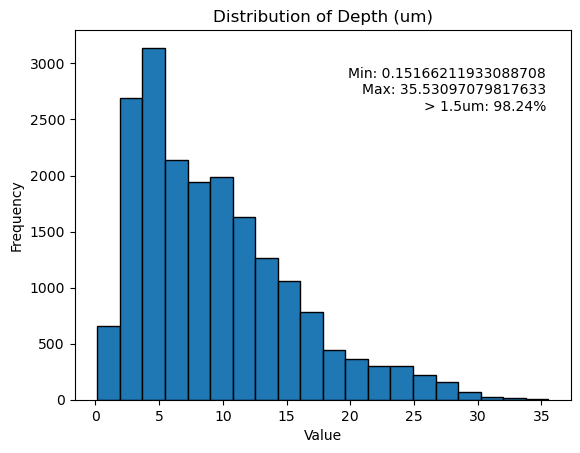

In [44]:
import pandas as pd
import matplotlib.pyplot as plt


last_column = soma_in_brain.iloc[:, -1]

min_value = last_column.min()
max_value = last_column.max()

print(f"最小值: {min_value}")
print(f"最大值: {max_value}")

# 计算大于 0.5 的数值占比
greater_than_0_5 = (last_column > 1.5).mean()
print(f"大于 0.5 的数值占比: {greater_than_0_5 * 100:.2f}%")

# 绘制直方图（适用于数值型数据）
plt.hist(last_column, bins=20, edgecolor='black')
plt.title("Distribution of Depth (um)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.text(0.95, 0.9, f"Min: {min_value}\nMax: {max_value}\n> 1.5um: {greater_than_0_5 * 100:.2f}%", 
         ha='right', va='top', transform=plt.gca().transAxes)

# 显示图表
plt.show()

In [45]:
soma_in_brain.to_csv("depth.csv",index=False)

## 3.2 Look at whether a particular type of neuronal cell body is present in the brain parenchyma

In [40]:
import pandas as pd
import numpy as np
import trimesh
from tqdm import tqdm

input_path = r'H:\fly\dataframe_data\meta_data_mannual_check.csv'
df_meta = pd.read_csv(input_path, dtype={0: str})
df = df_meta.copy()

mesh_path = r'H:\code\BrainParcellation-main\data\fly_mesh\whole_mesh\merge_all.obj'
mesh = trimesh.load(mesh_path)

def calculate_distance_to_surface(point):
    result = mesh.nearest.on_surface([point])
    closest_point = result[0][0]  
    distance_to_surface = np.linalg.norm(point - closest_point)
    is_inside = mesh.contains([point])[0]
    return -distance_to_surface if is_inside else distance_to_surface

tqdm.pandas(desc="Calculating distances")

df['distance_to_surface'] = df.progress_apply(
    lambda row: calculate_distance_to_surface(np.array([row['soma_x'], row['soma_y'], row['soma_z']])),
    axis=1
)


Calculating distances: 100%|████████████████| 134689/134689 [51:09<00:00, 43.88it/s]


In [41]:
df

,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z,in_brain,in_brain_numeric,mannual_check,distance_to_surface
0,720575940617317718,138.09089,365.16053,157.406030,1,Unipolar,1.711,LA_L,138.090890,365.160530,157.406030,Yes,1,Unipolar,-13.109351
1,720575940616753894,442.73788,235.72992,226.249940,1,Unipolar,1.927,PLP_L,426.890432,235.348252,209.753087,No,0,Unipolar,11.821135
2,720575940624765959,832.87906,251.00790,76.269030,1,Unipolar,2.095,LA_R,830.562572,252.049488,82.309802,No,0,Unipolar,5.053010
3,720575940622071412,740.55260,323.32856,79.795770,1,Unipolar,2.607,ME_R,737.149300,318.612314,94.126347,No,0,Unipolar,13.965796
4,720575940636178239,327.98280,170.85694,221.622750,1,Unipolar,1.681,PVLP_L,356.488295,193.495347,172.147376,No,0,Unipolar,2.518521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134684,720575940608327435,819.12725,253.64138,228.757340,1,Unipolar,1.697,ME_R,819.250674,253.126543,224.022500,No,0,Unipolar,3.264347
134685,720575940621425134,324.19840,224.93297,270.030900,1,Unipolar,1.258,ME_L,267.175712,210.982766,251.874520,No,0,Unipolar,5.904015
134686,720575940613200706,536.36844,197.72828,191.784610,1,Unipolar,2.102,IPS_R,561.989303,236.822731,184.282588,No,0,Unipolar,13.068719
134687,720575940634001247,697.79944,305.70020,122.060695,1,Unipolar,1.784,ME_R,700.979290,307.190783,123.747950,No,0,Unipolar,1.228617


In [42]:
df.to_csv("dis_to_surface.csv", index=False)

## 3.3 Venn plot

In [10]:
import glob
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_circles

def get_swc_filenames(path):
    swc_files = glob.glob(os.path.join(path, "*.swc"))
    filenames = {os.path.splitext(os.path.basename(f))[0] for f in swc_files}
    return filenames

path1 = '/home/ylx/fly/sk_lod1_783_healed'  # all neuron
path2 = '/home/ylx/fly/data_rename'        # neuron with soma
path3 = '/home/ylx/fly/axon_file'          # neuron with synapses

# 获取每个路径下的文件名（不含扩展名）
filenames1 = get_swc_filenames(path1)
filenames2 = get_swc_filenames(path2)
filenames3 = get_swc_filenames(path3)

set1 = set(filenames1)
set2 = set(filenames2)
#set3 = set(filenames3)
set3 = set(all_neuron_df.iloc[:, 0])

# 转换为集合后，计算各个交集
only_set1 = set1 - (set2 | set3)
only_set2 = set2 - (set1 | set3)
only_set3 = set3 - (set1 | set2)
set1_and_set2 = set1 & set2 - set3
set2_and_set3 = set2 & set3 - set1
set1_and_set3 = set1 & set3 - set2
set1_and_set2_and_set3 = set1 & set2 & set3

# 打印检查每个集合的大小
print(f"Only Set1: {len(only_set1)}")
print(f"Only Set2: {len(only_set2)}")
print(f"Only Set3: {len(only_set3)}")
print(f"Set1 & Set2: {len(set1_and_set2)}")
print(f"Set2 & Set3: {len(set2_and_set3)}")
print(f"Set1 & Set3: {len(set1_and_set3)}")
print(f"Set1 & Set2 & Set3: {len(set1_and_set2_and_set3)}")

# 计算交集大小
subsets = {
    '100': len(only_set1),  # 只在 Set1 中
    '010': len(only_set2),  # 只在 Set2 中
    '001': len(only_set3),  # 只在 Set3 中
    '110': len(set1_and_set2),  # Set1 和 Set2 的交集
    '101': len(set1_and_set3),  # Set1 和 Set3 的交集
    '011': len(set2_and_set3),  # Set2 和 Set3 的交集
    '111': len(set1_and_set2_and_set3)  # Set1, Set2 和 Set3 的交集
}




Only Set1: 953
Only Set2: 0
Only Set3: 0
Set1 & Set2: 4204
Set2 & Set3: 0
Set1 & Set3: 3631
Set1 & Set2 & Set3: 130485


## calculate

In [14]:
file_path = 'dataframe_data/meta_data_mannual_check.csv'
df_meta = pd.read_csv(file_path, dtype={0: str})
counts = df_meta[df_meta['mannual_check']=="Multipolar"]['Soma_region'].value_counts()
#counts.to_csv("out.csv", header=True)
#df_meta[(df_meta['branches_count']==4)] # & (df_meta["radius"]>=5)]
#df_meta['mannual_check'].value_counts()
df_meta[df_meta['mannual_check']=="Bipolar"]['in_brain'].value_counts()

in_brain
Yes    8012
No     1251
Name: count, dtype: int64

In [4]:
import pandas as pd
file_path = 'dataframe_data/meta_data.csv'
df_meta = pd.read_csv(file_path, dtype={0: str})
df_meta[df_meta['Name']=="720575940618562950"]

,Name,soma_x,soma_y,soma_z,branches_count,type,radius,Soma_region,projected_x,projected_y,projected_z,in_brain,in_brain_numeric
107980,720575940618562950,625.6259,266.63812,69.60704,1,Unipolar,2.298,WED_R,619.858868,269.276392,91.205337,No,0


In [5]:
import pandas as pd
import numpy as np
import trimesh
from scipy.spatial import cKDTree

input_path = 'dataframe_data/meta_data.csv'
df_meta = pd.read_csv(input_path, dtype={0: str})
df_meta[df_meta["type"]=="Multipolar"].to_csv("Multipolar_list.csv", index=False)

In [10]:
file_path2 = r"G:\fly\dataframe_data\meta_data.csv"
file_path3 = r"G:\fly\dataframe_data\proj_test_copy.csv"

meta_df = pd.read_csv(file_path2,dtype={"Name":str})
proj_df = pd.read_csv(file_path3,dtype={"Name":str})
merge_df = pd.merge(proj_df[["Name"]], meta_df, on='Name', how='left')
merge_df['Soma_region'] = merge_df['Soma_region'].str.replace(r'_R$|_L$', '', regex=True)
merge_df["Soma_region"].value_counts()

Soma_region
ME        63809
LO        14407
LA         6759
MB_CA      4655
AVLP       3620
LOP        3287
GNG        3228
SMP        3089
LH         2646
SLP        2605
AL         2512
PLP        1857
FB         1668
IPS        1511
SPS        1233
PVLP        895
LAL         860
SAD         789
ICL         749
AOTU        710
CRE         685
PRW         563
WED         442
NO          427
SCL         423
VES         394
SIP         362
EB          360
AMMC        316
FLA         293
MB_ML       284
OCG         172
IB          131
PB          112
MB_VL        57
ATL          45
MB_PED       35
AME          33
GOR          24
EPA           8
CAN           7
GA            7
Name: count, dtype: int64